# 네이버 영화 리뷰 긍/부정 분류

목표 : 네이버 영화 리뷰 글을 딥러닝 모델에 적용하여 긍/부정 분류를 높은 성능으로 진행해보자

In [23]:
# 각 패키지 설치방법 정리

# ubuntu openjdk 설치
# !sudo apt-get update
# !sudo apt-get install openjdk-8-jdk -y
# java -version
#openjdk version "1.8.0_275"
#OpenJDK Runtime Environment (build 1.8.0_275-8u275-b01-0ubuntu1~18.04-b01)
#OpenJDK 64-Bit Server VM (build 25.275-b01, mixed mode)

#konlpy 설치
# !pip install konlpy

# mecab-ko 설치
#https://somjang.tistory.com/entry/PythonUbuntu%EC%97%90-mecab-ko-dic-%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC-%EC%84%A4%EC%B9%98%ED%95%98%EA%B8%B0
#cd ~/다운로드
#wget https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
#압축 풀기 tar xvfz mecab-0.996-ko-0.9.2.tar.gz
# cd /home/aiffel/aiffel/exp4_movie_rating/dataset/mecab-0.996-ko-0.9.2
# ./configure
# make
# make check
# sudo make install
# sudo ldconfig
# mecab --version
#mecab of 0.996/ko-0.9.2

# mecab-ko dic 설치
#cd ~/Downloads
#wget https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
#압축 풀고
#cd mecab-ko-dic-2.1.1-20180720
# ./configure
# make
# sudo make install
# 설치 여부 확인 mecab -d /usr/local/lib/mecab/dic/mecab-ko-dic 실행 후 문장 입력

# sudo apt install curl git
# bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

# 위대로 다 설치하면 2가지 에러가 남
# 1) name 'tagger' is not defined
# 2) typeerror: startjvm() got an unexpected keyword argument 'convertstrings'

# 1)은 https://sosomemo.tistory.com/30 참고하여
# cd /tmp/mecab-python-0.996
# python3 setup.py build
# python3 setup.py install

# 2)은TypeError: startJVM() got an unexpected keyword argument 'convertStrings'
# 참고 블로그 - https://i-am-eden.tistory.com/9
#cd /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy
# sudo nano(vi나 gedit 이나 편하신 편집기 사용) jvm.py 
# 맨 마지막 줄 convertStrings=True 부분만 주석처리하고, )는 살려주고 저장.


패키지 불러오기

In [24]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os

In [25]:
# 데이터를 읽어봅시다. 
train_data_path = os.getenv('HOME') + '/aiffel/exp/exp4/dataset/sentiment_classification/ratings_train.txt'
test_data_path = os.getenv('HOME') + '/aiffel/exp/exp4/dataset/sentiment_classification/ratings_test.txt'

# train / test 각각 불러와서
train_data = pd.read_table(train_data_path)
test_data = pd.read_table(test_data_path)

# train data head 보자
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [26]:
# test data head 보자

test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [27]:
from konlpy.tag import Mecab
# mecab tokenizer 를 사용한다.
tokenizer = Mecab()
# 아래 stopword 들은 형태소로써 제외한다. 
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # document 부분만 필요하여 꺼내쓰겠다.
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # 빈 거를 제외한다. NAN 제거
    train_data = train_data.dropna(how = 'any') 
    # document 부분만 필요하여 꺼내쓰겠다.
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # 빈 거를 제외한다. NAN 제거
    test_data = test_data.dropna(how = 'any') 

    # return 할 x_train list 를 초기화 해준 뒤에
    X_train = []
    # document 안의 영화평을 긁어서 각각
    for sentence in train_data['document']:
        # 형태소 단위로 쪼갠 뒤에
        temp_X = tokenizer.morphs(sentence) # 토큰화
        # 불용어 제거한다.
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        # 담는다
        X_train.append(temp_X)

    # train 과 동일하다
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # list 를 np concatenate
    words = np.concatenate(X_train).tolist()
    # 단어 숫자를 세어서 'the':100 개 이런 식으로 dict 형태로 표현한다.
    counter = Counter(words)
    # 전체 형태소 중에서 가장 많이 사용하는 10000-4 개만 취하겠다.
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    # enumerate 를 적용하여 단어:숫자 조합으로 진행한다.
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [28]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 

# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [38]:
print(get_decoded_sentence(X_train[0], word_to_index))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
라벨:  0


In [41]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다.


PAD 채워주기

In [44]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## TRAIN / VALIDATION / TEST DATASET 분리

In [52]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(X_val.shape)
print(y_val.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(10000, 41)
(10000,)
(136182, 41)
(136182,)


## RNN-LSTM 모델 설계

In [53]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_LSTM.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_LSTM.add(keras.layers.Dense(8, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


RNN-LSTM 학습시키자

In [59]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_LSTM = model_LSTM.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Train on 136182 samples, validate on 10000 samples
Epoch 1/10
136182/136182 [==============================] - 3s 24us/sample - loss: 0.1624 - accuracy: 0.9375 - val_loss: 0.5036 - val_accuracy: 0.8454
Epoch 2/10
136182/136182 [==============================] - 2s 11us/sample - loss: 0.1535 - accuracy: 0.9406 - val_loss: 0.5249 - val_accuracy: 0.8434
Epoch 3/10
136182/136182 [==============================] - 2s 11us/sample - loss: 0.1476 - accuracy: 0.9437 - val_loss: 0.5414 - val_accuracy: 0.8428
Epoch 4/10
136182/136182 [==============================] - 2s 11us/sample - loss: 0.1431 - accuracy: 0.9462 - val_loss: 0.5856 - val_accuracy: 0.8413
Epoch 5/10
136182/136182 [==============================] - 2s 12us/sample - loss: 0.1419 - accuracy: 0.9462 - val_loss: 0.5831 - val_accuracy: 0.8407
Epoch 6/10
136182/136182 [==============================] - 2s 11us/sample - loss: 0.1352 - accuracy: 0.9487 - val_loss: 0.6099 - val_accuracy: 0.8413
Epoch 7/10
136182/136182 [=================

In [60]:
results = model_LSTM.evaluate(X_test,  y_test, verbose=2)
print(results)

49157/1 - 2s - loss: 0.9035 - accuracy: 0.8344
[0.6918347935924223, 0.8344488]


In [63]:
history_dict_LSTM = history_LSTM.history
print(history_dict_LSTM.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


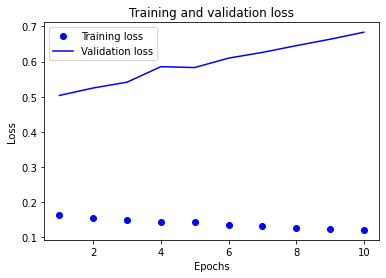

In [64]:
import matplotlib.pyplot as plt

acc = history_dict_LSTM['accuracy']
val_acc = history_dict_LSTM['val_accuracy']
loss = history_dict_LSTM['loss']
val_loss = history_dict_LSTM['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## CNN 모델 설계

In [47]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.MaxPooling1D(5))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(8, activation='relu'))
model_CNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [84]:
model_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=2  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_CNN = model_CNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Train on 136182 samples, validate on 10000 samples
Epoch 1/2
136182/136182 [==============================] - 2s 14us/sample - loss: 0.0306 - accuracy: 0.9901 - val_loss: 1.1508 - val_accuracy: 0.8119
Epoch 2/2
136182/136182 [==============================] - 1s 9us/sample - loss: 0.0254 - accuracy: 0.9922 - val_loss: 1.1525 - val_accuracy: 0.8159


In [85]:
results_CNN = model_CNN.evaluate(X_test,  y_test, verbose=2)
print(results_CNN)

49157/1 - 2s - loss: 1.5121 - accuracy: 0.8101
[1.1732053824324888, 0.81013894]


In [86]:
history_dict_CNN = history_CNN.history
print(history_dict_CNN.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


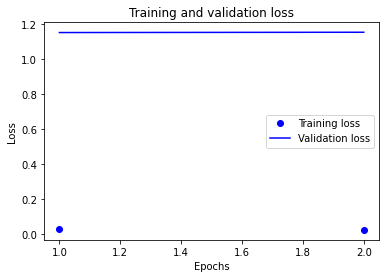

In [87]:
import matplotlib.pyplot as plt

acc = history_dict_CNN['accuracy']
val_acc = history_dict_CNN['val_accuracy']
loss = history_dict_CNN['loss']
val_loss = history_dict_CNN['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## CNN_ECLASS 모델 설계

In [48]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_CNN_ECLASS = keras.Sequential()
model_CNN_ECLASS.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN_ECLASS.add(keras.layers.GlobalMaxPooling1D())
model_CNN_ECLASS.add(keras.layers.Dense(8, activation='relu'))
model_CNN_ECLASS.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN_ECLASS.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [92]:
model_CNN_ECLASS.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_CNN_ECLASS = model_CNN_ECLASS.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Train on 136182 samples, validate on 10000 samples
Epoch 1/3
136182/136182 [==============================] - 1s 11us/sample - loss: 0.1525 - accuracy: 0.9455 - val_loss: 0.5227 - val_accuracy: 0.8316
Epoch 2/3
136182/136182 [==============================] - 1s 7us/sample - loss: 0.1478 - accuracy: 0.9475 - val_loss: 0.5339 - val_accuracy: 0.8293
Epoch 3/3
136182/136182 [==============================] - 1s 8us/sample - loss: 0.1440 - accuracy: 0.9495 - val_loss: 0.5452 - val_accuracy: 0.8269


In [93]:
results_CNN_ECLASS = model_CNN_ECLASS.evaluate(X_test,  y_test, verbose=2)
print(results_CNN_ECLASS)

49157/1 - 2s - loss: 0.6459 - accuracy: 0.8250
[0.5519991851035817, 0.82503]


In [94]:
history_dict_CNN_ECLASS = history_CNN_ECLASS.history
print(history_dict_CNN_ECLASS.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


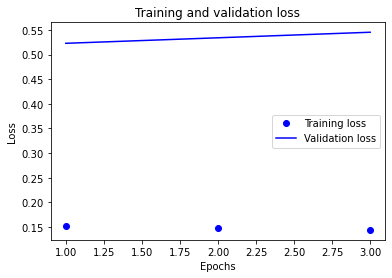

In [95]:
import matplotlib.pyplot as plt

acc = history_dict_CNN_ECLASS['accuracy']
val_acc = history_dict_CNN_ECLASS['val_accuracy']
loss = history_dict_CNN_ECLASS['loss']
val_loss = history_dict_CNN_ECLASS['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [105]:
import gensim
import os

word2vec_path = os.getenv('HOME') + '/aiffel/exp/exp4/word2vec_pretrained/ko.bin'
model = gensim.models.Word2Vec.load(word2vec_path)

In [106]:
result = model.wv.most_similar("강아지")
print(result)

[('고양이', 0.7290453314781189), ('거위', 0.7185634970664978), ('토끼', 0.7056223750114441), ('멧돼지', 0.6950401067733765), ('엄마', 0.693433403968811), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.675035297870636), ('아빠', 0.6729634404182434), ('목걸이', 0.6512461304664612)]


In [112]:
print(model) # 모델의 크기 확인  Word2Vec(vocab=30185, size=200, alpha=0.025)

Word2Vec(vocab=30185, size=200, alpha=0.025)


In [130]:
from tensorflow.keras.initializers import Constant

vocab_size = 30185    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           6037000   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [138]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=2  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Train on 136182 samples, validate on 10000 samples
Epoch 1/2
136182/136182 [==============================] - 16s 117us/sample - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 2/2
136182/136182 [==============================] - 15s 109us/sample - loss: 0.6931 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5027


In [139]:
results_pretrained_word2vec = model.evaluate(X_test, y_test, verbose=2)
print(results_pretrained_word2vec)

49157/1 - 9s - loss: 0.6920 - accuracy: 0.4973
[0.6931759433759724, 0.49730456]


In [140]:
history_dict_pretrained_word2vec = history.history
print(history_dict_pretrained_word2vec.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


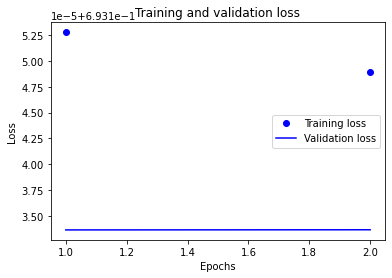

In [141]:
import matplotlib.pyplot as plt

acc = history_dict_pretrained_word2vec['accuracy']
val_acc = history_dict_pretrained_word2vec['val_accuracy']
loss = history_dict_pretrained_word2vec['loss']
val_loss = history_dict_pretrained_word2vec['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

느낀 점들

EPOCH 을 수십-수백번 돌려야 될것같았는데 생각 외로, VALIDATION LOSS GRAPH 를 보게되면 3번 이후부터 과적합이 되는 것을 확인하였다.

CNN 으로 문장 SEQUENCE를 학습한다는 것에 대해서 이해가 되지 않는다.
이에 대해 퍼실님들의 설명이 있으면 좋겠다.

WORD2VEC 을 적용하여 정확도가 떨어졌다. 떨어진 이유는 내가 잘 적용하지 못한 것 같다.
단어의 의미정보를 WORD2VEC 로 추가하여 넣어주었는데 과연 분류 성능이 떨어진다는 것이 말이 될까?
과연 말/글 의 정보에는 의미란 필요없고 단순 단어들의 조합에 불과한 것일까?

RNN 에 대해서 이해하지 못한 상태로 노드를 진행하다보니 학습이 잘 되지 않은 것 같다.
후에 개념을 잡고 나서 비슷한 노드가 있으면 과연 잘 할 수 있을까?

영화 평가 글들은 사실 구어체로 쓰여져있다. 대체로
이것을 위키피디아 같은 문어체 단어들을 학습한 PRETRAINED 모델을 적용하여 학습하는게 맞는 것일까?

NLP 라고하는 자연어처리를 통해서 어떤 문제를 해결할 수 있는데 적용가능한지 다양한 사례를 보고싶다.